This script will attempt to process and plot echosounder and amplitude Data as a means of understanding sediment characteristics.

In [3]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.io import loadmat

In [4]:
deployment_num = 1
sensor_id = "E1_103071"
# directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [5]:
# Import seabird data
sbepath = "Z:\deployment_1\Raw\E1RBR\SBE_00003570_DEP4_FPSE1_L0.mat"
stuff = loadmat(
    sbepath
)  # Load mat oragnizes the 4 different data structures of the .mat file (Units, Config, Data, Description) as a
# dictionary with four nested numpy arrays with dtypes as data field titles
sbe = {}
for names in stuff.keys():
    sbe[names] = stuff[
        names
    ]  # Convert the numpy arrays to a dictionary with the data field titles as keys
    print(names)
del stuff

__header__
__version__
__globals__
SN
time
conductivity
temperature
pressure
salinity
units
notes


In [6]:
# Create dictionary for each sensor
dirpath = os.path.join(
    directory_initial_user_path,
    f"deployment_{deployment_num}/Processed/",
    f"{sensor_id}",
    "Group39",
)  # path to the directory containing the h5 files
files = os.listdir(dirpath)  # list of files for the sensor
Data = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    Data[file_name] = df  # store Dataframe
globals()[f"Data_{sensor_id}"] = Data

AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth
Echo1
Echo2
CellDepth_echo
AmpBeam1
AmpBeam2
AmpBeam3
AmpBeam4
VbAmplitude


In [7]:
filepath = "Z:\deployment_1\BulkStats\E1_103071"
files = os.listdir(filepath)  # list of files for the sensor
waves = {}
for file in files:
    file_path = os.path.join(filepath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    waves[file_name] = df  # store Dataframe
globals()[f"waves_{sensor_id}"] = waves

DepthAveragedCurrentVelocity
DepthAveragedEastVelocity
DepthAveragedFlowDirection
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
EastVelSpectra
Echo1avg
Echo2avg
Frequencies
GroupSpeed
MeanDirection1
MeanDirection2
MeanPeriod
MeanSpread1
MeanSpread2
NorthVelSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
PressureSpectra
SedTime
SignificantWaveHeight
Time
Vertavg
VolumetricBackscatter1
VolumetricBackscatter2
WaveCelerity
WaveNumbers


Look at magnitudes 23.722167725693946 0.32593752906287954 35.552402


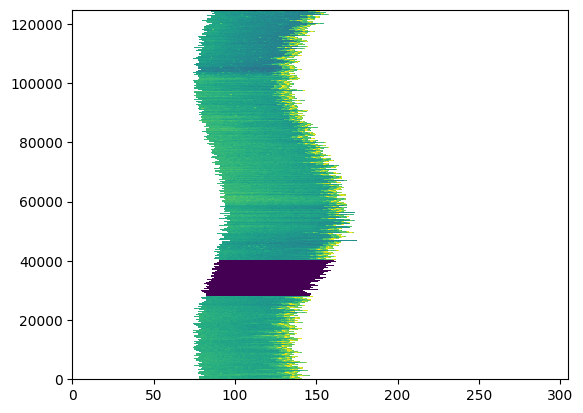

In [ ]:
"""This section will test calculate target strength"""


# Attempts at sediment attentuation of the amplitude data, at the start are the required parameters for calculation
def sediment_analysis(Echo, S, T, P, CellDepth_echo, Burst_Pressure, transmit_length):

    ph = 8.1
    freq = 1000  # kHz
    transmit_power = 0
    beam_angle = 0.015
    Csv = 0
    transmit_length_sec = transmit_length / 1000

    # Convert to arrays
    echo_array = Echo.values
    ranges = CellDepth_echo.values.flatten()  # shape (n_cells,)
    n_samples, n_cells = echo_array.shape

    # build depth matrix
    pressures = Burst_Pressure.values.flatten()  # shape (n_samples,)
    depths_matrix = pressures[:, None] - ranges[None, :]  # shape (n_samples, n_cells)
    depths_matrix[depths_matrix <= 0] = 0

    range_matrix = np.tile(ranges, (n_samples, 1))  # shape (n_samples, n_cells)

    

    T0 = float(np.nanmean(T))
    S0 = float(np.nanmean(S))

    # Sound speed
    soundspeed = (
        1448.96 + 4.591 * T0 - 5.304e-2 * T0**2 + 2.374e-4 * T0**3 + 1.34 * (S0 - 35)
    )

    # Attenuation coefficients
    A_1 = (8.66 * 10 ** (0.78 * ph - 5)) / soundspeed
    A_2 = (21.44 * S0 * (1 + 0.025 * T0)) / soundspeed
    f_1 = 2.8 * np.sqrt(S0 / 35) * 10 ** (4 - 1245 / (T0 + 273))
    f_2 = (8.17 * 10 ** (8 - (1990 / (T0 + 273)))) / (1 + 0.0018 * (S0 - 35))

    P_2 = 1 - 1.37e-4 * depths_matrix + 6.2e-9 * depths_matrix**2
    P_3 = 1 - 3.83e-5 * depths_matrix + 4.9e-10 * depths_matrix**2

    if T0 <= 20:
        A_3 = 4.937e-4 - 2.59e-5 * T0 + 3.2e-7 * T0**2 - 1.5e-8 * T0**3
    else:
        A_3 = 3.964e-4 - 1.146e-5 * T0 + 1.45e-7 * T0**2 - 6.5e-10 * T0**3

    # absorption, shape: (n_samples, n_cells)
    a_w = (freq**2) * (
        ((A_1 * f_1) / (f_1**2 + freq**2))
        + ((A_2 * P_2 * f_2) / (f_2**2 + freq**2))
        + A_3 * P_3
    )
    a_w /= 1000  # dB/m

    # Sv calculation
    Sv = (
        echo_array * 0.43
        + 20 * np.log10(range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
        - 10 * np.log10((soundspeed * transmit_length_sec) / 2)
        - beam_angle
        + Csv
    )

    print("Look at magnitudes",20 * np.log10(range_matrix).max(),a_w.max(),np.nanmax(echo_array*.43))

    # TS calculation
    TS = (
        echo_array * 0.43
        + 40 * np.log10(10 * range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
    )

    # Convert back to DataFrames
    Sv_df = pd.DataFrame(Sv, index=Echo.index, columns=Echo.columns)
    TS_df = pd.DataFrame(TS, index=Echo.index, columns=Echo.columns)

    # mean echo amplitude
    echoavg = Echo.mean(axis=1)

    return echoavg, Sv_df, TS_df, depths_matrix


Echo1avg, S_v1, TS, depths_matrix = sediment_analysis(
    Data["Echo1"],
    sbe["salinity"],
    sbe["temperature"],
    sbe["pressure"],
    Data["CellDepth_echo"],
    Data["Pressure"],
    0.330,
)

# Echo2avg, S_v2, ___, ___ = sediment_analysis(
#     Data["Echo2"],
#     sbe["salinity"],
#     sbe["temperature"],
#     sbe["pressure"],
#     Data["CellDepth_echo"],
#     Data["Pressure"],
#     0.033,
# )


topmask = np.zeros(depths_matrix.shape, dtype=bool)
bottommask = np.zeros(depths_matrix.shape, dtype=bool)
depths_matrix_no_nan = np.nan_to_num(depths_matrix,nan = 0.0)

for i in range(depths_matrix.shape[0]):
    
    surface = depths_matrix_no_nan[i,:].max()
    middle = surface / 2
    bottommask[i,:] = depths_matrix_no_nan[i,:] < middle
    topmask[i,:] = depths_matrix_no_nan[i,:] >= middle

botscatt = Data['Echo1'].mask(bottommask,np.nan) #Finds the mean of the top half of scattering values
topscatt =  Data['Echo1'].mask(topmask,np.nan) #Finds the mean of the bottom half of scattering values



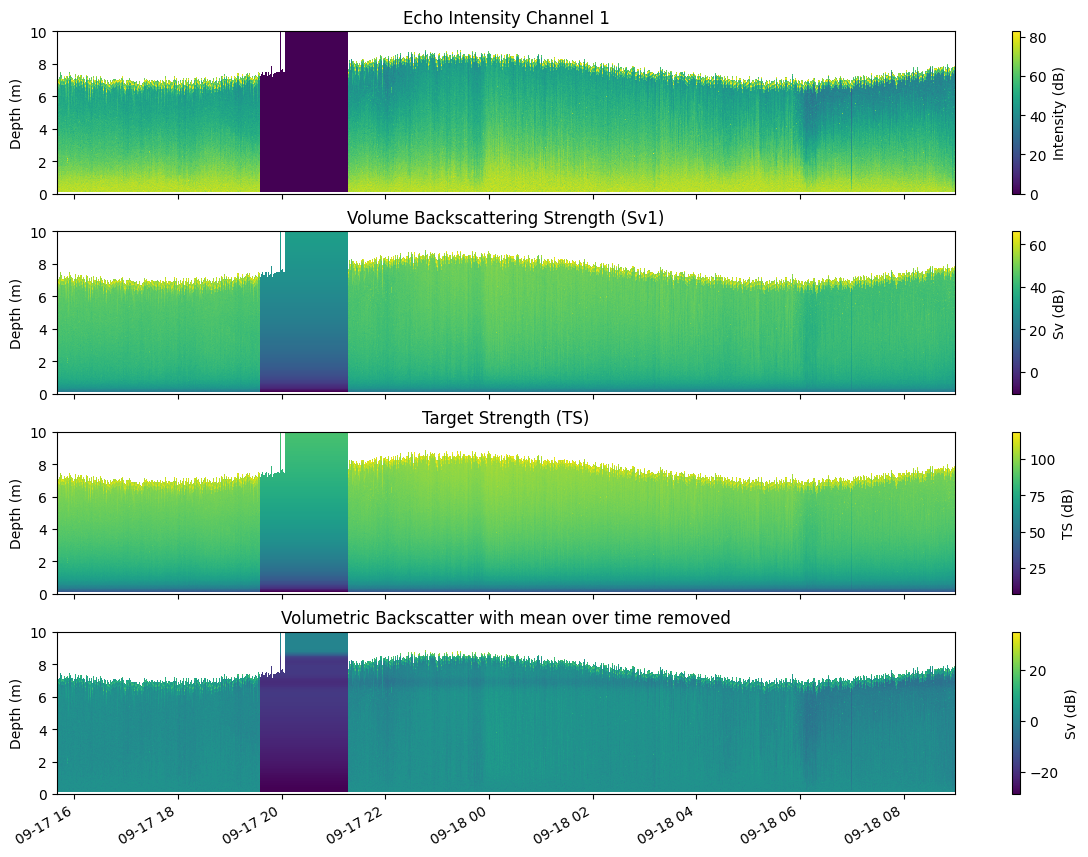

In [ ]:
"""This section will generate plots to look at echosounder backscatter and target strength"""

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot 1: Echo1
pcm0 = axs[0].pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    Data["Echo1"].T,
    shading="auto",
    cmap="viridis",
)
axs[0].set_title("Echo Intensity Channel 1")
axs[0].set_ylabel("Depth (m)")
cbar0 = fig.colorbar(pcm0, ax=axs[0], orientation="vertical")
cbar0.set_label("Intensity (dB)")

# Plot 2: S_v1
pcm1 = axs[1].pcolormesh(
    Data["Time"][0], Data["CellDepth_echo"], S_v1.T, shading="auto"
)
axs[1].set_title("Volume Backscattering Strength (Sv1)")
axs[1].set_ylabel("Depth (m)")
cbar1 = fig.colorbar(pcm1, ax=axs[1], orientation="vertical")
cbar1.set_label("Sv (dB)")

# Plot 3: TS
pcm2 = axs[2].pcolormesh(
    Data["Time"][0], Data["CellDepth_echo"], TS.T, shading="auto"
)
axs[2].set_title("Target Strength (TS)")
axs[2].set_ylabel("Depth (m)")
cbar2 = fig.colorbar(pcm2, ax=axs[2], orientation="vertical")
cbar2.set_label("TS (dB)")

# Plot 4: Optional – leave blank or add another variable
pcm3 = axs[3].pcolormesh(
    Data["Time"][0], Data["CellDepth_echo"], (S_v1 - np.nanmean(S_v1,axis = 0)).T, shading="auto"
)
axs[3].set_title("Volumetric Backscatter with mean over time removed")
axs[3].set_ylabel("Depth (m)")
cbar3 = fig.colorbar(pcm3, ax=axs[3], orientation="vertical")
cbar3.set_label("Sv (dB)")



for ax in axs:
    ax.set_ylim(0,10)
# General layout tweaks
plt.tight_layout()
fig.autofmt_xdate(rotation=30)

plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_Sv_Echo_TS_.png")

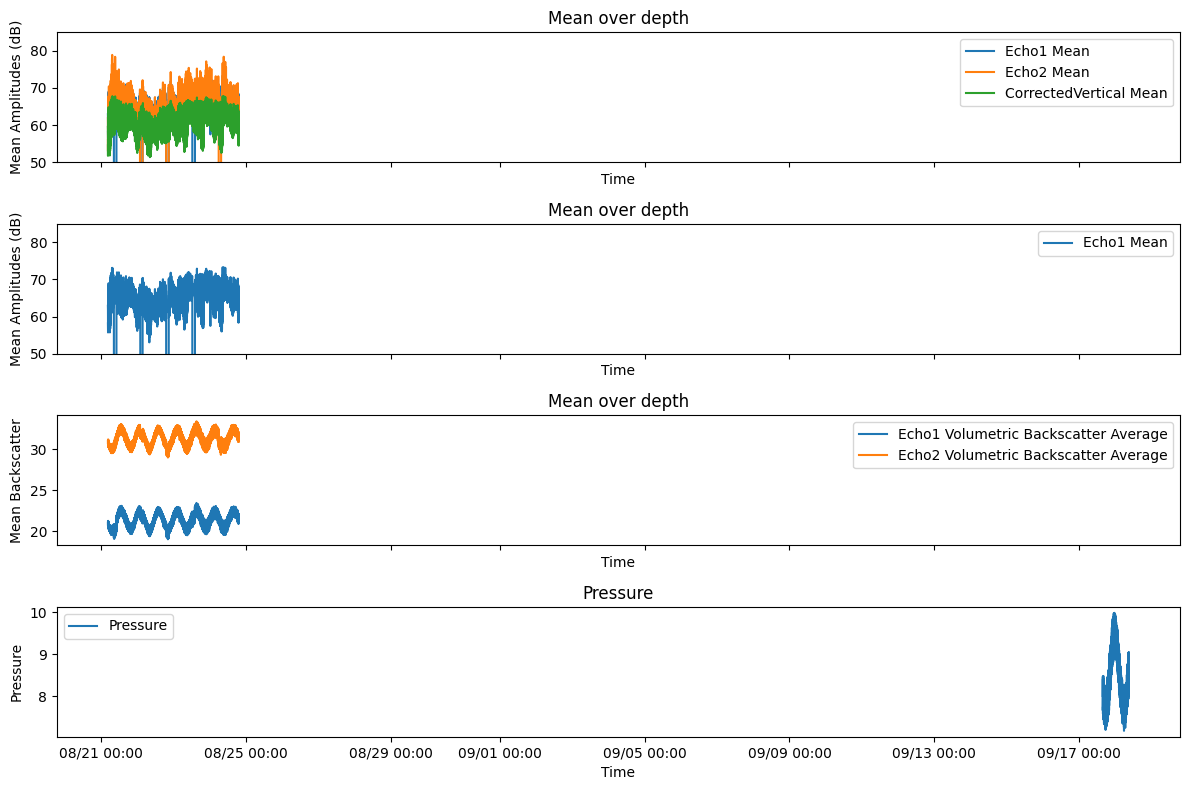

In [ ]:
# Integrated and avg backscatter over depth bins (you have to avg the echosounder to same bin size as vertbeam first)


fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[0].plot(waves["SedTime"], waves["Echo2avg"], label="Echo2 Mean")
axs[0].plot(waves["SedTime"], waves["Vertavg"] - 17, label="CorrectedVertical Mean")
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(50, 85)
axs[0].legend()

axs[1].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Amplitudes (dB)")
axs[1].set_xlabel("Time")
axs[1].set_ylim(50, 85)
axs[1].legend()

axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter1"],
    label="Echo1 Volumetric Backscatter Average",
)
axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter2"],
    label="Echo2 Volumetric Backscatter Average",
)
axs[2].set_title("Mean over depth")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend()

axs[3].plot(Data["Time"], Data["Pressure"], label="Pressure")
axs[3].set_title("Pressure")
axs[3].set_ylabel("Pressure")
axs[3].set_xlabel("Time")
axs[3].legend()

for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_backscatter_.png")

***This section will perform some analyses on Vertical Beam and Echosounder***

In [ ]:
from scipy.stats import linregress

ratio = waves["Echo1avg"] / waves["Vertavg"]
m, b, r2, pval, stderr = linregress(waves["Echo1avg"], waves["Vertavg"])

plt.figure(figsize=(12, 4))
plt.plot(Data["Time"], ratio, label="Vertical / Echo1 mean-over-depth")
plt.axhline(
    ratio.mean(), color="red", linestyle="--", label=f"Mean ratio ≈ {ratio.mean():.2f}"
)
plt.xlabel("Time (mm-dd HH)")
plt.ylabel("Ratio (unitless) ")
plt.title("Ratio of mean-over-depth (Vertical Beam vs Echo1)")
plt.legend()
plt.grid()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_meanratios.png")


# plt.figure(figsize=(6,6))
# plt.scatter(echo1_avg, vertical_avg, alpha=0.5, label='Data')
# plt.plot(echo1_avg, m*echo1_avg + b, color='red', label='Fit')
# plt.xlabel('Echo1 mean over depth')
# plt.ylabel('Vertical beam mean over depth')
# plt.title('Least-squares fit')
# plt.legend()
# plt.grid()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_linregmeans.png")

print(b, m, r2)

MemoryError: Unable to allocate 11.3 TiB for an array with shape (1248000, 1248000) and data type float64

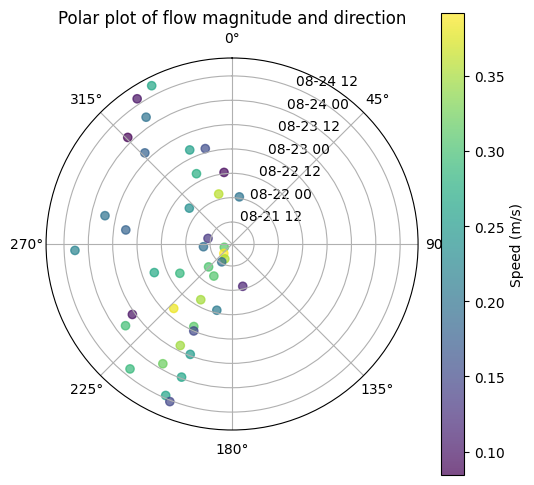

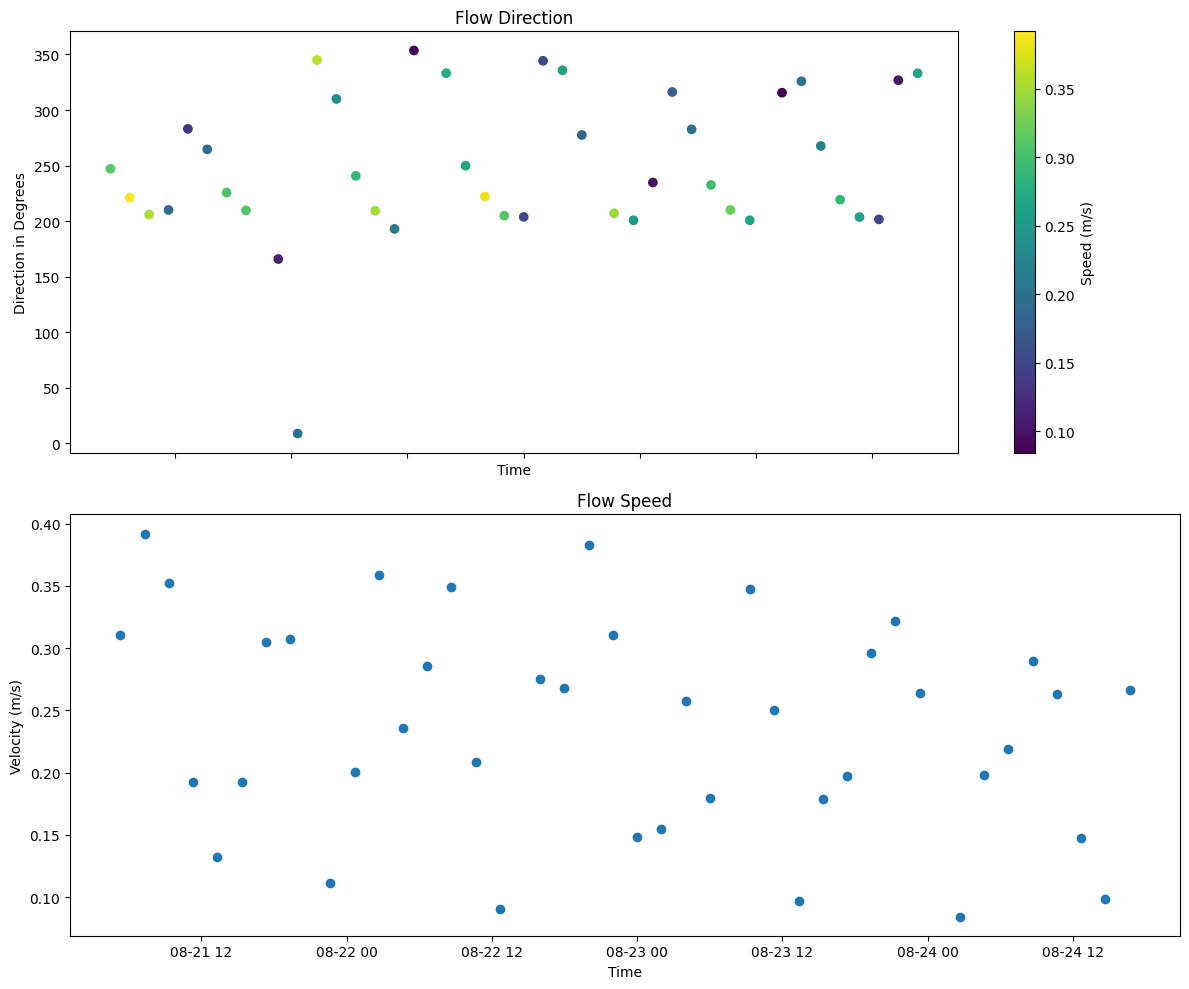

In [ ]:
# Orbital plot to look at flow direction


# Convert to radians
speed = waves["DepthAveragedCurrentVelocity"]

dir_rad = np.deg2rad(waves["DepthAveragedFlowDirection"])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
sc = ax.scatter(dir_rad, waves["Time"].values, c=speed, cmap="viridis", alpha=0.7)

ax.set_theta_zero_location("N")  # set 0° at north
ax.set_theta_direction(-1)  # clockwise
plt.title("Polar plot of flow magnitude and direction")
plt.colorbar(sc, label="Speed (m/s)")
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_polarflowdir.png")

figs, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
gg = axs[0].scatter(waves["Time"].values, waves["DepthAveragedFlowDirection"], c=speed)
plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")

gg1 = axs[1].scatter(waves["Time"].values, waves["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time")
axs[1].set_title("Flow Speed")
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")